In [1]:
%matplotlib widget

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import statsmodels.api as sm
from matplotlib import cm
import matplotlib as mpl
plt.style.use('presentation.mplstyle')


In [2]:
path_root = r"C:\Users\coren\Documents\PhD\temp\datatables"


In [3]:
paths = [path for path in os.listdir(path_root) if path.split('.')[-1]=='csv']
paths

['201209_Plate40(1).csv',
 '201210_Plate39(1).csv',
 '201210_Plate40(1).csv',
 '201217_Plate09.csv',
 '201217_Plate10(1).csv',
 '201217_Plate38(1).csv',
 '211012_Plate799(1).csv']

In [4]:
table = pd.DataFrame()
for path in paths:
    table = pd.concat([table,pd.read_csv(os.path.join(path_root,path))])

In [19]:
table['days'] = table['time_since_crossing']/pd.Timedelta(days=1)

In [38]:
mean

days
3.357639          NaN
3.360417     1.245351
11.352083         NaN
17.497222    1.154248
20.393056         NaN
21.576389         NaN
Name: bias, dtype: float64

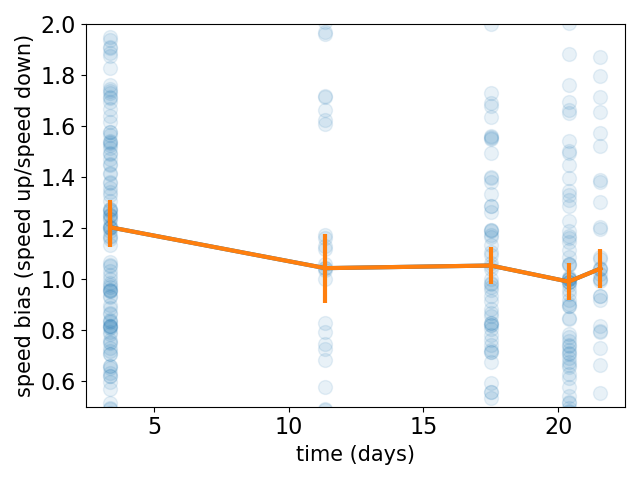

In [67]:
fig,ax = plt.subplots()
table['bias']=-table['speed+']/table['speed-']
table['bias'] = table['bias'].replace(np.inf,1)
table['bias'] = table['bias'].replace(-np.inf,1)
select = table.loc[table['bias']<5]
ax.scatter(select['days'],select['bias'],alpha =0.1)
ax.set_ylim(0.5,2)
mean = select.groupby('days')["bias"].median()
std = select.groupby('days')["bias"].std()
count = select.groupby('days')["bias"].count()
ax.plot(mean.index,mean)
ax.errorbar(mean.index,mean,std/np.sqrt(count))
ax.set_xlabel('time (days)')
ax.set_ylabel('speed bias (speed up/speed down)')
plt.tight_layout()

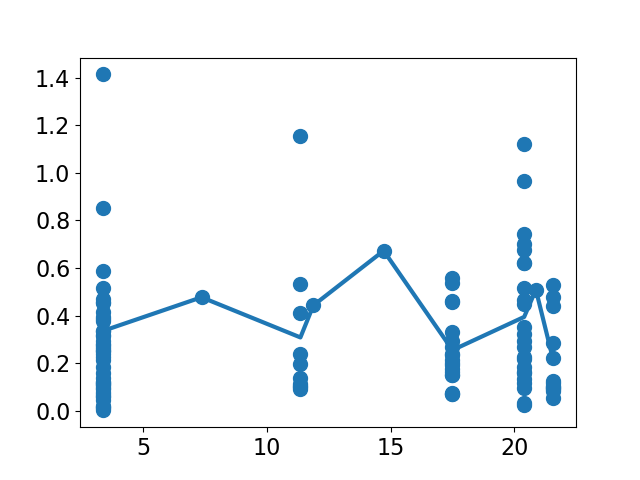

In [50]:
fig,ax = plt.subplots()
std = table.groupby(['posy'])['speed+'].std()
mean = table.groupby(['posy'])['speed+'].mean()
count = table.groupby(['posy'])['speed+'].count()
days_columns = table.groupby(['posy'])['days'].mean()
grouping = 3
column=(mean/grouping).astype(int)*grouping
dataf = pd.DataFrame(mean)
dataf['speed_int'] = column
dataf['days'] = days_columns

dataf['CV'] = std/mean

average = dataf.groupby('days')['CV'].mean()
ax.scatter(days_columns,std/mean)
ax.plot(average.index,average)

KeyError: 'speed'

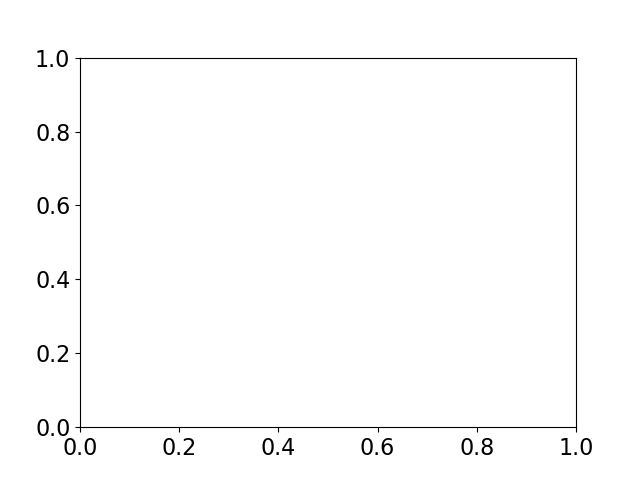

In [9]:
fig,ax = plt.subplots()
ax.scatter(table['tot_num_spore'],table[f"speed"],alpha = 0.1)
group = table.groupby('tot_num_spore')['speed'].median()
ax.plot(group.index,group)
group_error = table.groupby('tot_num_spore')['speed'].std()
group_count = table.groupby('tot_num_spore')['speed'].count()

ax.errorbar(group.index,group, group_error/np.sqrt(group_count))
ax.set_xlabel('number of spores')
ax.set_ylabel('max speed ($\mu m.s^{-1}$)')
ax.set_yscale('log')
ax.set_ylim(2,100)
plt.tight_layout()

In [14]:
column = table['speed+']+table['speed-']
column = column.replace(np.inf,0)
column = column.replace(-np.inf,0)

np.mean(column),np.std(column)/np.sqrt(len(column))

(-0.05448060903426778, 0.536651903223975)

In [15]:
def make_stat(x0,ax):
    def statistic(x,y):
        # X = sm.add_constant(x, prepend=False)
        X = x
        model = sm.OLS(y,X)
        res = model.fit()
        a = res.params[0]
        ax.plot(x0,np.array(x0)*a,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

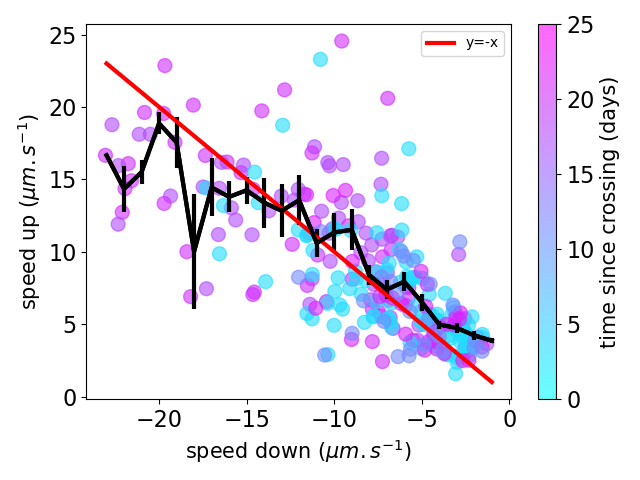

In [66]:
fig,ax = plt.subplots()
cmap=cm.get_cmap("cool", 100)

select = table.loc[table['speed+'].between(1,25)]
select = select.loc[select['speed-'].between(-25,-1)]
max_day = 25
norm = mpl.colors.Normalize(vmin=0, vmax=max_day)

scatter = ax.scatter(select['speed-'],select['speed+'],c=select['days'],cmap ="cool",alpha = 0.6,norm=norm)

select['speed-group'] = select['speed-'].replace(-np.inf,0).astype(int)
group = select.groupby('speed-group')['speed+'].median()
ax.plot(group.index,group,color='black')
group_error = select.groupby('speed-group')['speed+'].std()
group_count = select.groupby('speed-group')['speed+'].count()
statistic = make_stat(group.index,ax)
data = np.array((group.index,group))
n_resamples = 100
# std = scipy.stats.bootstrap(data,statistic,
#                             vectorized = False,
#                             method="basic",
#                             n_resamples = n_resamples,
#                             paired= True).standard_error
ax.errorbar(group.index,group, group_error/np.sqrt(group_count),color="black")
ax.plot(group.index,-group.index,color='red',label="y=-x")
ax.set_xlabel("speed down ($\mu m.s^{-1}$)")
ax.set_ylabel("speed up ($\mu m.s^{-1}$)")
ax.legend()
fig.colorbar(scatter,label="time since crossing (days)",ax=ax)
plt.tight_layout()


In [10]:
# grouping_window_mult = 13
# table['group_density'] = (table[f"spore_density_{size}"]*grouping_window_mult).astype(int)
size = 1000
table['group_density'] = table[f"spore_density_num_{size}"]
speedp = table.groupby('group_density')['speed+'].median()
speedm = table.groupby('group_density')['speed-'].median()
speedp_error = table.groupby('group_density')['speed+'].std()
speedp_count = table.groupby('group_density')['speed+'].count()

speedm = table.groupby('group_density')['speed-'].median()
speedm_error = table.groupby('group_density')['speed-'].std()
speedm_count = table.groupby('group_density')['speed-'].count()

# space_pixel_size = 1.725
speedp.index 

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64', name='group_density')

Text(0, 0.5, 'maximum speeds ($\\mu m.s^{-1}$)')

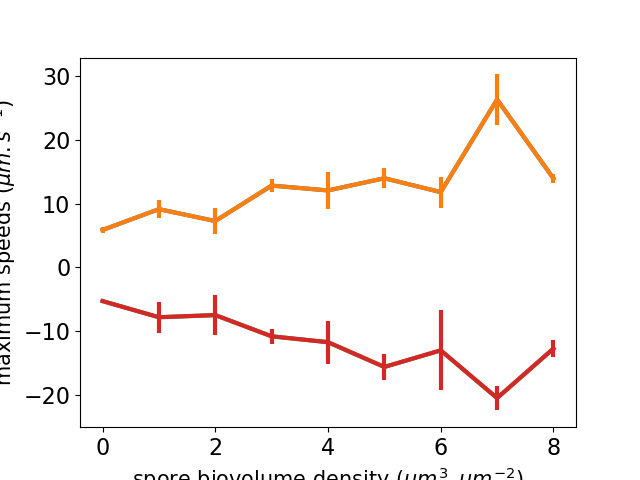

In [11]:
fig,ax = plt.subplots()
# ax.scatter(table["group_density"]/grouping_window_mult/space_pixel_size**2,table['speed-'])
ax.plot(speedp.index,speedp)
ax.errorbar(speedp.index,speedp,speedp_error/np.sqrt(speedp_count))
ax.plot(speedp.index,speedm)
ax.errorbar(speedp.index,speedm,speedm_error/np.sqrt(speedm_count))
ax.set_xlabel('spore biovolume density ($\mu m^{3}.\mu m^{-2}$)')
ax.set_ylabel('maximum speeds ($\mu m.s^{-1}$)')



In [72]:
table['speed']

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
Name: speed, Length: 260, dtype: float64

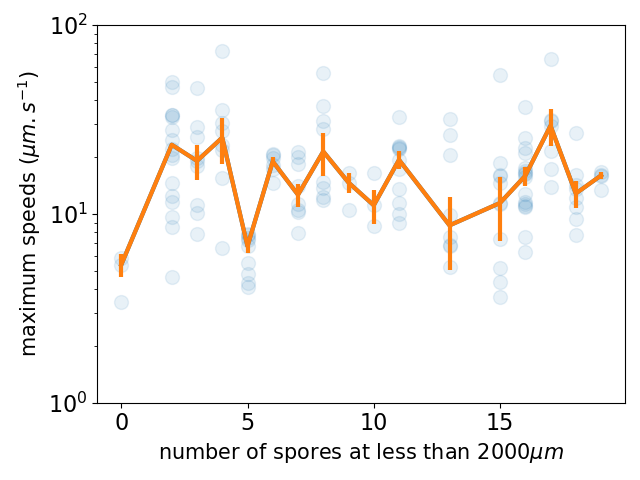

In [12]:
size = 2000
table['group_density'] = table[f"spore_density_num_{size}"]
table['abs_speed-'] = -table['speed-']
table['speed'] = table[['speed+','abs_speed-']].max(1)
select = table.loc[table['tot_num_spore']>=200]
speed = select.groupby('group_density')['speed'].median()
speed_error = select.groupby('group_density')['speed'].std()
speed_count = select.groupby('group_density')['speed'].count()
fig,ax = plt.subplots()
ax.scatter(select[f"spore_density_num_{size}"],select[f"speed"],alpha = 0.1)

# ax.scatter(table["group_density"]/grouping_window_mult/space_pixel_size**2,table['speed-'])
ax.plot(speed.index,speed)
ax.errorbar(speed.index,speed,speed_error/np.sqrt(speed_count))
# ax.plot(speedp.index,speedm)
# ax.errorbar(speedp.index,speedm,speedm_error/np.sqrt(speedm_count))
ax.set_xlabel(f'number of spores at less than {size}$\mu m$')
ax.set_ylabel('maximum speeds ($\mu m.s^{-1}$)')
ax.set_yscale('log')
ax.set_ylim(1,100)
plt.tight_layout()